# This notebook is for the Chicago Taxi dataset.

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score as CHScore
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.decomposition import PCA

In [182]:
df = pd.read_csv("../datasets/chicago_taxi.csv")
df.head(3)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,fec6b8b1c5cd7af9e6dc4e9c8c46fb08987f2e9c,56a1119c6ca57e39525cf06829f9ecff553cf4b5ac2482...,01/24/2020 12:15:00 AM,01/24/2020 12:15:00 AM,322.0,0.80,NaN,NaN,8.0,28.0,...,0.0,5.75,Cash,Medallion Leasin,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.874005,-87.663518,POINT (-87.6635175498 41.874005383)
1,ff5cad1f181d44fe60b9d0a1330f78269511d54a,6acd828b5cde8b4529317e8eda5b4fb9663fa81d1143c9...,01/24/2020 12:15:00 AM,01/24/2020 12:30:00 AM,671.0,5.17,NaN,NaN,8.0,3.0,...,0.0,16.75,Credit Card,Chicago Carriage Cab Corp,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
2,fbe685844176dd7822b6e256efce7fa3f8909e4b,b968bad5a2daed924a10e8ec4fb35513e060a076c575f7...,01/24/2020 12:15:00 AM,01/24/2020 12:30:00 AM,960.0,0.40,NaN,NaN,8.0,3.0,...,0.0,22.60,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)


In [183]:
#Let's have a look at the columns in the dataframe
df.dtypes

Trip ID                        object
Taxi ID                        object
Trip Start Timestamp           object
Trip End Timestamp             object
Trip Seconds                  float64
Trip Miles                    float64
Pickup Census Tract           float64
Dropoff Census Tract          float64
Pickup Community Area         float64
Dropoff Community Area        float64
Fare                          float64
Tips                          float64
Tolls                         float64
Extras                        float64
Trip Total                    float64
Payment Type                   object
Company                        object
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Pickup Centroid Location       object
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid  Location     object
dtype: object

## I will get rid of these columns:
- *Trip ID*: it's just a unique id.
- *Taxi ID*: it's also a unique id for a taxi.
- *Fare, Tolls, and Extras*: I will keep *Trip Total* and *Tips* because it could be interesting.
- *Company*: I don't want to deal with all the company names.
- *Pickup/Dropoff Centroid Location*: We have the individual longitudes and latitudes already.
- *Trip Start/End Timestamp*: We have to convert those into timestamps, maybe another time.
- *Payment Type*: This is categorical data.
- *Pickup/Dropoff Census Tract*: We have an area column interchangeable with these.

In [184]:
df.drop(['Trip ID',
         'Taxi ID',
         'Fare',
         'Tolls',
         'Extras',
         'Company',
         'Pickup Centroid Location',
         'Dropoff Centroid  Location',
         'Trip Start Timestamp',
         'Trip End Timestamp',
         'Payment Type',
         'Pickup Census Tract',
         'Dropoff Census Tract'], axis=1, inplace=True)

In [185]:
#Let's see how the null values are looking
df.isna().sum()

Trip Seconds                     37
Trip Miles                        4
Pickup Community Area         19728
Dropoff Community Area        25580
Tips                             28
Trip Total                       28
Pickup Centroid Latitude      19711
Pickup Centroid Longitude     19711
Dropoff Centroid Latitude     25013
Dropoff Centroid Longitude    25013
dtype: int64

In [186]:
#For the following fields I believe a median value will do the trick.
#This is because there are few of these fields missing
df['Trip Seconds'].fillna(df['Trip Seconds'].median(), inplace=True)
df['Trip Miles'].fillna(df['Trip Miles'].median(), inplace=True)
df['Tips'].fillna(df['Tips'].median(), inplace=True)
df['Trip Total'].fillna(df['Trip Total'].median(), inplace=True)

#This might be controversial, but I decided to drop the rows with null values in the other fields
#There are lots of those missing
df.dropna(inplace=True)



In [187]:
#Here's our data after handling the null values
#No more null values!
df.isna().sum()

Trip Seconds                  0
Trip Miles                    0
Pickup Community Area         0
Dropoff Community Area        0
Tips                          0
Trip Total                    0
Pickup Centroid Latitude      0
Pickup Centroid Longitude     0
Dropoff Centroid Latitude     0
Dropoff Centroid Longitude    0
dtype: int64

In [188]:
#Let's scale the dataframe with StandardScaler

#Instantiating the Scaler
scaler = StandardScaler().fit(df)

#Scaling the data and putting it in a new dataframe
df_scaled = pd.DataFrame(scaler.transform(df))

#Let's get our column names back
df_scaled.columns = df.columns

#And here is our scaled dataframe
df_scaled.head(3)

,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Tips,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,-0.342106,-0.439599,-0.934874,0.307437,-0.614170,-0.098005,0.077089,0.347473,-0.557218,-0.231046
1,-0.072725,0.417494,-0.934874,-1.149210,-0.251882,-0.005521,0.077089,0.347473,1.731194,-0.090711
2,0.150344,-0.518051,-0.934874,-1.149210,0.780639,0.043663,0.077089,0.347473,1.731194,-0.090711


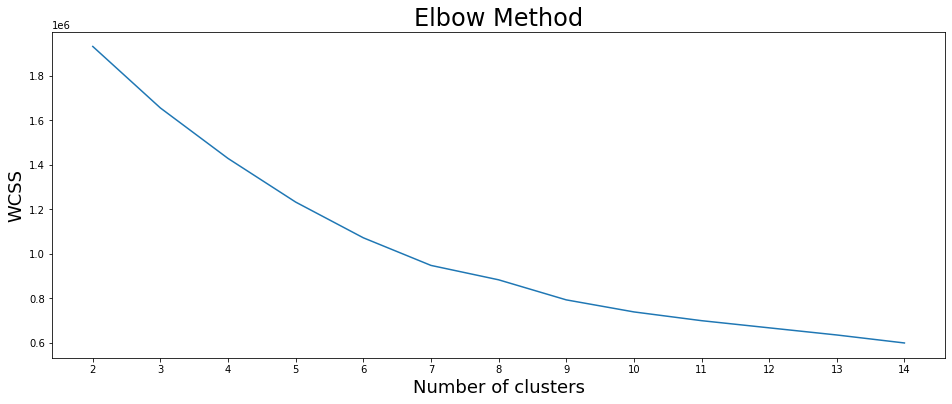

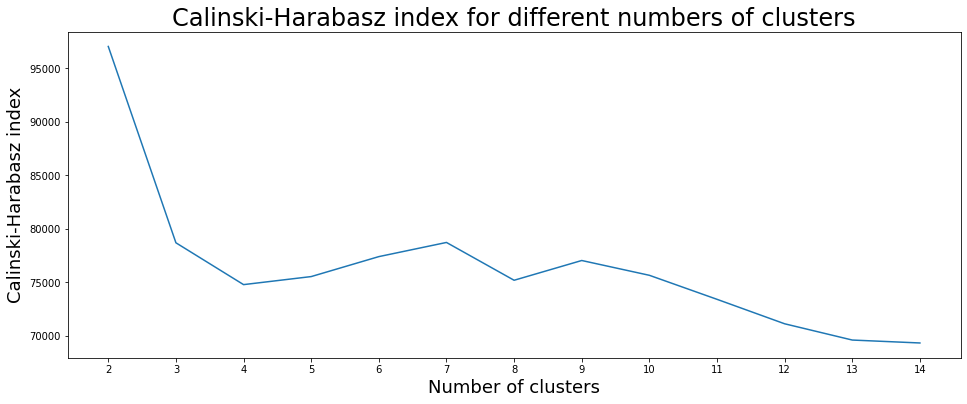

In [189]:
#Maximum number of clusters to fit
maxClusters = 15
n_cluster = range(2, maxClusters)

#Running KMeans with different values for k
kmeans = [KMeans(n_clusters = i,
                 init='k-means++',
                 max_iter=300, n_init=10,
                 random_state=0).fit(df_scaled)
          for i in n_cluster]

#Getting the inertiae
inertiae = [abs(kmeans[i].inertia_) for i in range(len(kmeans))]

#Getting the labels for the CH index calculation
labels = [k.labels_ for k in kmeans]

#Calculating the CH indexes
CH_scores = [CHScore(df_scaled, l) for l in labels]

f = plt.figure(1, figsize=(16, 6))
plt.plot(n_cluster, inertiae)
plt.title("Elbow Method", size=24)
plt.xticks(n_cluster)
plt.ylabel("WCSS", size=18)
plt.xlabel("Number of clusters", size=18)

g = plt.figure(2, figsize=(16, 6))
plt.plot(n_cluster, CH_scores)
plt.title("Calinski-Harabasz index for different numbers of clusters", size=24)
plt.xticks(n_cluster)
plt.ylabel("Calinski-Harabasz index", size=18)
_ = plt.xlabel("Number of clusters", size=18)

In [190]:
# This is a pretty tough call, but I am going to pick k = 7 for the cluster size as it looks like it is the elbow of the WCSS curve and it seems to maximize the CH index for a number of clusters greater than 4

In [191]:
#Let's run KMeans on the data with k = 7
kmeans = KMeans(n_clusters = 7,
                 init='k-means++',
                 max_iter=300, n_init=10,
                 random_state=0).fit(df_scaled)

In [192]:
#I create a column that specifies the cluster prediction for each row
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

#Here's the dataframe with the cluster predictions
df_scaled.head(10)

,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Tips,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Cluster
0,-0.342106,-0.439599,-0.934874,0.307437,-0.614170,-0.098005,0.077089,0.347473,-0.557218,-0.231046,4
1,-0.072725,0.417494,-0.934874,-1.149210,-0.251882,-0.005521,0.077089,0.347473,1.731194,-0.090711,0
2,0.150344,-0.518051,-0.934874,-1.149210,0.780639,0.043663,0.077089,0.347473,1.731194,-0.090711,0
3,-0.498023,-0.596504,-0.934874,-0.857881,-0.614170,-0.112719,-0.093289,0.439468,-0.096019,0.454256,0
4,-0.312775,-0.321920,0.070219,-0.857881,-0.614170,-0.081190,-0.537644,-0.044333,0.080818,0.323945,0
5,0.418182,1.045113,-0.934874,2.346742,-0.614170,0.053332,0.077089,0.347473,-2.515807,-0.835790,6
6,-0.249482,-0.282694,0.070219,-0.857881,-0.614170,-0.083292,-0.537644,-0.044333,0.080818,0.323945,0
7,-0.590647,-0.596504,-0.934874,-0.857881,-0.614170,-0.110617,-0.131373,0.534750,-0.135546,0.589222,0
8,2.124005,1.364806,-0.934874,-1.207476,-0.614170,0.175243,0.077089,0.347473,2.622540,-0.809654,0
9,-0.456342,-0.455289,-0.985129,-0.916146,0.472694,0.059638,0.631481,0.137615,0.656224,0.026683,0


In [196]:
pca = PCA(n_components = 2)

df_scaled['pca_x'] = pca.fit_transform(df_scaled)[:, 0]
df_scaled['pca_y'] = pca.fit_transform(df_scaled)[:, 1]

df_scaled.reset_index()


,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Tips,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Cluster,pca_x,pca_y
0,-0.342106,-0.439599,-0.934874,0.307437,-0.614170,-0.098005,0.077089,0.347473,-0.557218,-0.231046,4,1.926103,-0.709348
1,-0.072725,0.417494,-0.934874,-1.149210,-0.251882,-0.005521,0.077089,0.347473,1.731194,-0.090711,0,-2.684980,-0.755911
2,0.150344,-0.518051,-0.934874,-1.149210,0.780639,0.043663,0.077089,0.347473,1.731194,-0.090711,0,-2.705433,-0.718434
3,-0.498023,-0.596504,-0.934874,-0.857881,-0.614170,-0.112719,-0.093289,0.439468,-0.096019,0.454256,0,-1.959969,-1.853516
4,-0.312775,-0.321920,0.070219,-0.857881,-0.614170,-0.081190,-0.537644,-0.044333,0.080818,0.323945,0,-1.960276,-1.109537
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264142,-0.217064,-0.302307,-1.035384,-0.916146,0.834982,-0.028642,1.148795,0.053190,0.656224,0.026683,0,-2.623951,-0.466105
264143,-0.266463,-0.576891,0.070219,0.482234,-0.614170,-0.045457,-0.537644,-0.044333,-1.148947,-0.305483,4,2.257591,-0.325584
264144,0.196656,0.305699,0.070219,-0.857881,0.490809,0.003307,-0.537644,-0.044333,0.080818,0.323945,0,-2.054830,-0.280135
264145,-0.034903,-0.165015,-0.934874,0.598766,-0.614170,-0.064375,-0.093289,0.439468,-0.922531,0.616970,4,2.177207,-0.811948
